In [1]:
import pandas as pd
import numpy as np
import os
%load_ext autoreload
%autoreload 2
from src.model.one_class import DeepSVDD
from src.model.reconstruction import DAGMM
from src.trainer.ids import DeepSVDDIDSTrainer, DAGMMIDSTrainer
from src.utils import metrics
from src.utils.utils import ids_misclf_per_label
from src.datamanager.dataset import IDS2017Dataset
from src.bootstrap import store_results
from datetime import datetime as dt

In [2]:
# Setup base folder structure
dataset_path = "../data/IDS2017/ids2017.csv"
export_path = "./%s" % dt.now().strftime("%m-%d-%Y_%H-%M-%S")
if not os.path.exists(export_path):
    os.mkdir(export_path)

# General arguments
batch_size = 1024
device = "cuda"
act_fn = "relu"
n_layers = 4
compression_factor = 2
lr = 1e-4
n_epochs = 200

# DeepSVDD-specific arguments
dsvdd_best_epoch = 106

# DAGMM-specific arguments
n_mixtures = 4
latent_dim = 1
lambda_1 = 0.005
lambda_2 = 0.1
reg_covar=1e-6
dagmm_best_epoch = 11

print("arguments set")

arguments set


In [3]:
dataset = IDS2017Dataset(path=dataset_path)
columns = dataset.columns[:-2]
partial_anomaly_labels = np.unique(dataset.labels)
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
print("data loaded")

data loaded


## DeepSVDD Training

In [4]:
dsvdd_model = DeepSVDD(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_layers=n_layers,
    compression_factor=compression_factor,
    act_fn=act_fn,
)
dsvdd_trainer = DeepSVDDIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    model=dsvdd_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    device=device,
    ckpt_fname=os.path.join(export_path, "deepsvdd"),
    run_test_validation=True
)
print("DeepSVDD model and trainer ready")

DeepSVDD model and trainer ready


In [6]:
_ = dsvdd_trainer.train(train_ldr)
dsvdd_trainer.save_ckpt(os.path.join(export_path, "deepsvdd.pt"))

y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=n_epochs, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

  1%|          | 7/1110 [00:00<00:28, 38.10it/s, epoch=1, loss=0.000]

Started training


100%|██████████| 1110/1110 [00:24<00:00, 45.24it/s, epoch=200, loss=0.000]


{'Precision': 0.5586405396883868,
 'Recall': 0.6418120553831035,
 'F1-Score': 0.5973450921256538,
 'AUPR': 0.7369894596347364,
 'AUROC': 0.8270542027936876,
 'Thresh_star': 5.083045095943817e-12,
 'Quantile_star': 62.18262734570128}

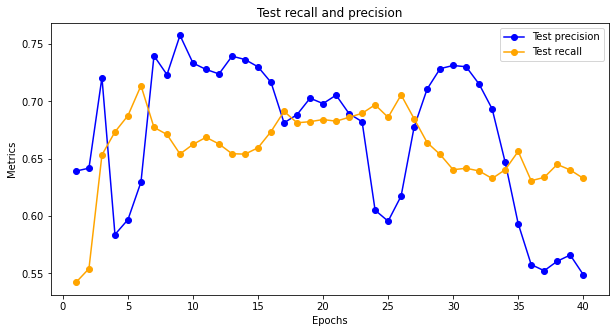

In [11]:
dsvdd_trainer.plot_metrics(export_path)

## Inspect misclassifications for every attack type

In [5]:
dsvdd_best_fname = os.path.abspath("./04-29-2022_11-34-47/checkpoints/deepsvdd_epoch=106.pt")
dsvdd_trainer, dsvdd_model = DeepSVDDIDSTrainer.load_from_file(dsvdd_best_fname, dsvdd_trainer, dsvdd_model)
y_test_true, test_scores, test_labels = dsvdd_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=106, **dsvdd_model.get_params()),
    model_name="DeepSVDD",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

{'Precision': 0.6892845497111212,
 'Recall': 0.6861127997661587,
 'F1-Score': 0.6876950176144943,
 'AUPR': 0.7572503960392325,
 'AUROC': 0.8307491939124647,
 'Thresh_star': 2.9990454564199354e-11,
 'Quantile_star': 67.23313239620633}

In [12]:
# Misclassified instances per label
misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
misclf_df = misclf_df.sort_values("Misclassified ratio", ascending=False)
misclf_df.to_csv(export_path + "/deepsvdd_misclassifications.csv")
misclf_df

,# Instances test set,Misclassified count,Misclassified ratio
SSH-Patator,5897,5889,0.998643
FTP-Patator,7938,7835,0.987024
Web Attack,2180,2075,0.951835
Bot,1966,1854,0.943032
PortScan,158930,78016,0.490883
DoS,252658,72053,0.285180
BENIGN,1136374,172471,0.151773
Infiltration,36,3,0.083333
DDoS,128027,7312,0.057113
Heartbleed,11,0,0.000000


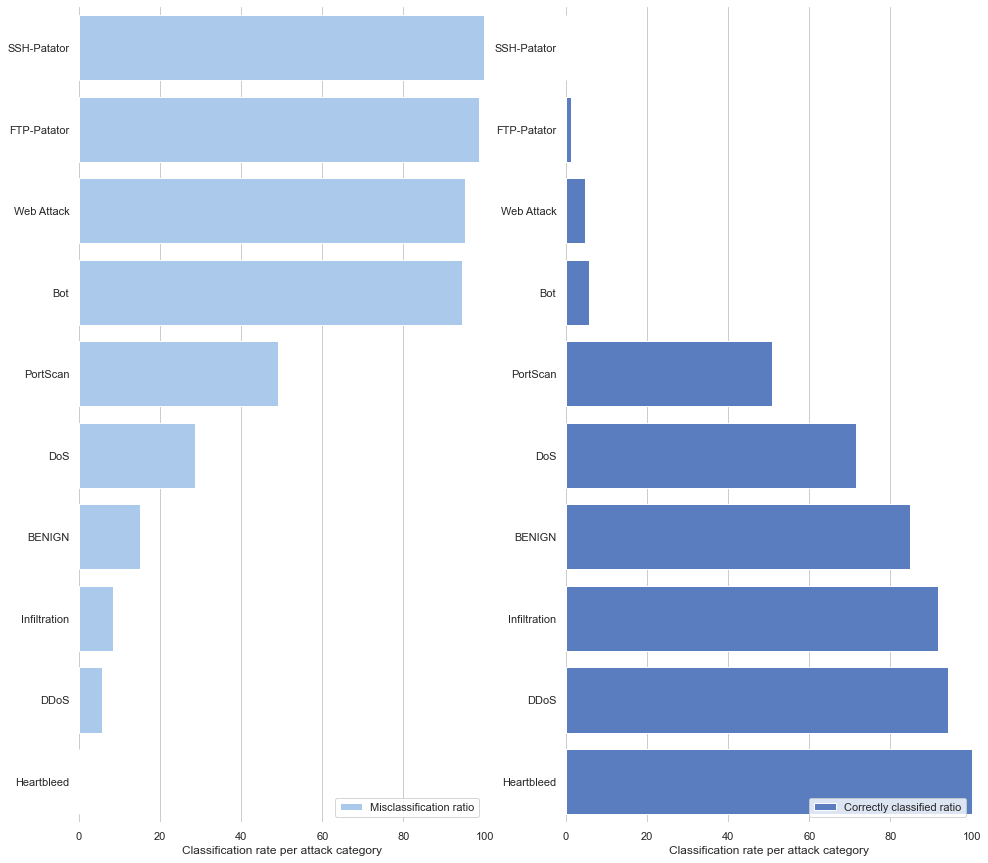

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

# Initialize the matplotlib figure
f, axs = plt.subplots(figsize=(16, 15), ncols=2)

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(
    x=misclf_df["Misclassified ratio"] * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Misclassification ratio",
    color="b",
    ax=axs[0]
)

# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
# sns.barplot(x="alcohol", y="abbrev", data=misclf_df,
#             label="Alcohol-involved", color="b")
sns.barplot(
    x=(1-misclf_df["Misclassified ratio"]) * 100,
    y=misclf_df.index,
    data=misclf_df,
    label="Correctly classified ratio",
    color="b",
    ax=axs[1]
)

# Add a legend and informative axis label
for ax in axs:
    ax.legend(ncol=2, loc="lower right", frameon=True)
    ax.set(xlim=(0, 100), ylabel="", xlabel="Classification rate per attack category")
sns.despine(left=True, bottom=True)

## Gradient analysis

In [55]:
d = dsvdd_trainer.inspect_gradient_wrt_input(test_ldr, partial_anomaly_labels)
y_grad, label_grad = d["y_grad_wrt_X"], d["label_grad_wrt_X"]
loss_hist, input_hist = d["losses"], d["input_mean"]
labels = d["labels"]

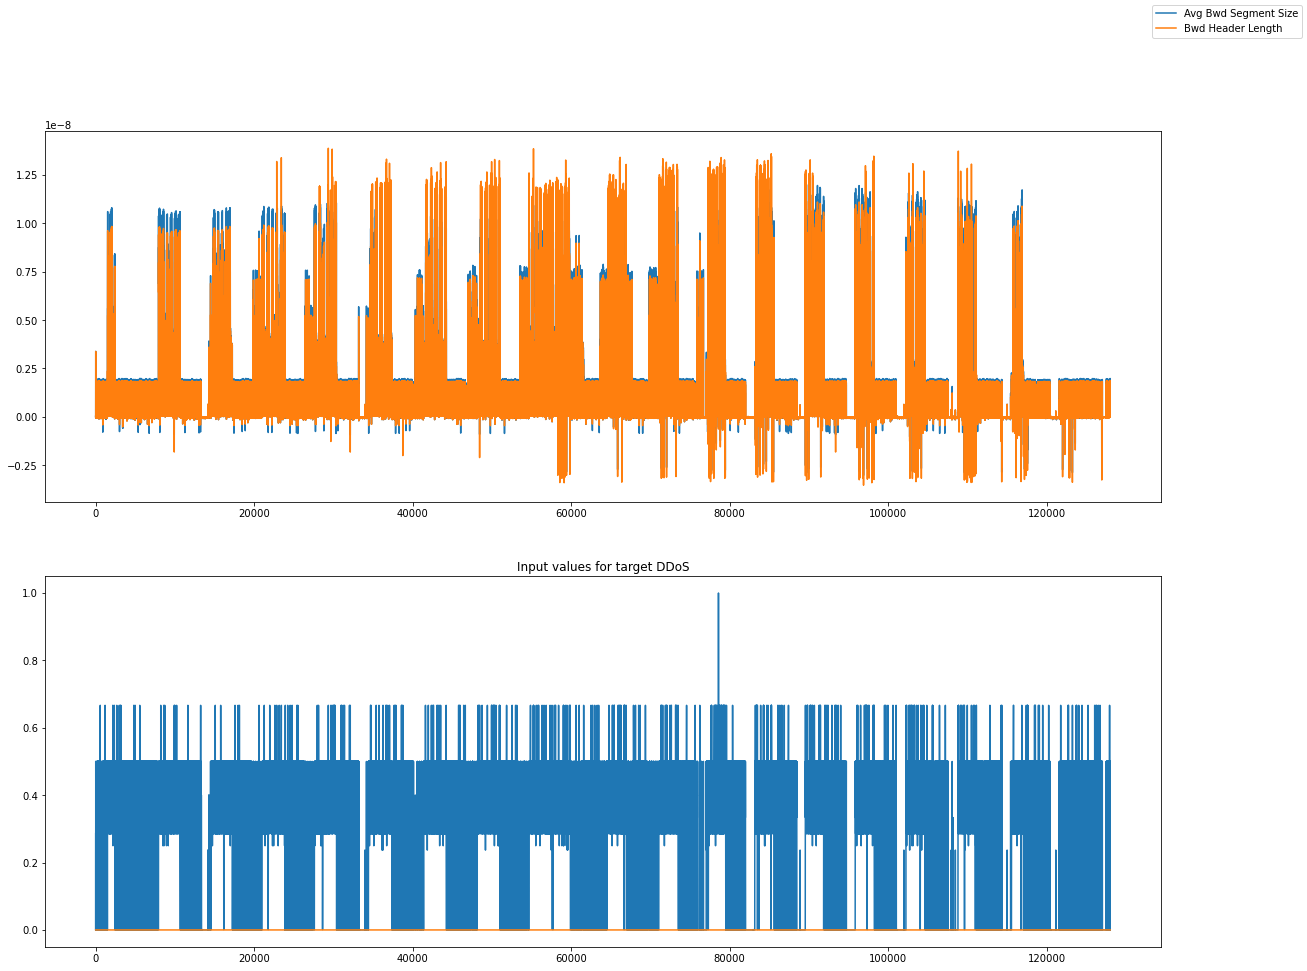

In [74]:
# DDoS analysis
import matplotlib.pyplot as plt

target_label = "DDoS"
f, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 15))
x = np.arange(1, label_grad[target_label].shape[0] + 1)
# for col in range(label_grad[target_label].shape[1]):
legend = []
for col_idx in [columns.index(col) for col in ["Avg Bwd Segment Size", "Bwd Header Length"]]:#, "Bwd Packet Length Mean"]]:
    axs[0].plot(x, label_grad[target_label][:, col_idx], "-")
    axs[1].plot(x, input_hist[labels == target_label][:, col_idx], "-")
    axs[1].title.set_text("Input values for target " + target_label)
    legend.append(columns[col_idx])
f.legend(legend)

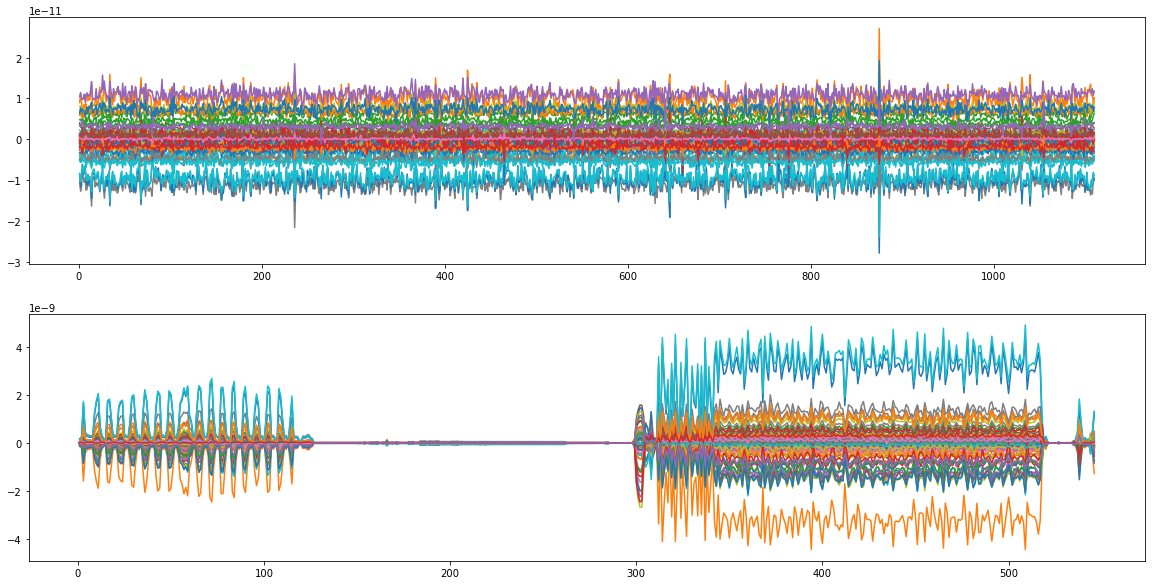

In [65]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
x = np.arange(1, y_grad[0].shape[0]+1)
for col in range(y_grad[0].shape[1]):
    axs[0].plot(x, y_grad[0][:, col], "-")

x = np.arange(1, y_grad[1].shape[0] +1)
for col in range(y_grad[1].shape[1]):
    axs[1].plot(x, y_grad[1][:, col], "-")

In [ ]:
import matplotlib.pyplot as plt

attack_labels = list(set(label_grad.keys()) - {"BENIGN"})
f, axs = plt.subplots(nrows=len(attack_labels), ncols=1, figsize=(20, 5 * len(attack_labels)))
for ax, label in zip(axs, attack_labels):
    x = np.arange(1, label_grad[label].shape[0]+1)
    for col in range(label_grad[label].shape[1]):
        ax.plot(x, label_grad[label][:, col], "-")
    ax.title.set_text(label)
plt.legend(columns)

In [ ]:
import matplotlib.pyplot as plt

attack_labels = list(set(label_grad.keys()) - {"BENIGN"})
f, axs = plt.subplots(nrows=len(attack_labels), ncols=1, figsize=(20, 5 * len(attack_labels)))
for ax, label in zip(axs, attack_labels):
    x = np.arange(1, label_grad[label].shape[0]+1)
    for col in range(label_grad[label].shape[1]):
        ax.plot(x, label_grad[label][:, col], "-")
    ax.title.set_text(label)
plt.legend(columns)

In [ ]:
ddos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), label_grad["DDoS"].sum(axis=0).reshape(65, 1) * 1e10),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
ddos_df["Sum of gradients"] = ddos_df["Sum of gradients"].astype(np.float32)
ddos_df.sort_values(by=["Sum of gradients"], ascending=False)

In [ ]:
dos_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), label_grad["DoS"].sum(axis=0).reshape(65, 1) * 1e10),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
dos_df["Sum of gradients"] = dos_df["Sum of gradients"].astype(np.float32)
dos_df.sort_values(by=["Sum of gradients"], ascending=False)

In [ ]:
portscan_df = pd.DataFrame(np.concatenate(
    (np.array(columns).reshape(65, 1), label_grad["PortScan"].sum(axis=0).reshape(65, 1) * 1e10),
    axis=1),
    columns=["Variable", "Sum of gradients"]
)
portscan_df["Sum of gradients"] = portscan_df["Sum of gradients"].astype(np.float32)
portscan_df.sort_values(by=["Sum of gradients"], ascending=False)

## DAGMM Training

In [21]:
dagmm_model = DAGMM(
    in_features=dataset.in_features,
    n_instances=dataset.n_instances,
    device=device,
    n_mixtures=n_mixtures,
    latent_dim=latent_dim,
    lambda_1=lambda_1,
    lambda_2=lambda_2,
    reg_covar=reg_covar,
    n_layers=n_layers,
    compression_factor=compression_factor,
    ae_act_fn="relu",
    gmm_act_fn="relu"
)
dagmm_trainer = DAGMMIDSTrainer(
    train_ldr=train_ldr,
    test_ldr=test_ldr,
    device=device,
    model=dagmm_model,
    batch_size=batch_size,
    lr=lr,
    n_epochs=n_epochs,
    ckpt_fname=os.path.join(export_path, "dagmm")
)
print("DAGMM model and trainer ready")

DAGMM model and trainer ready


In [8]:
train_ldr, test_ldr = dataset.loaders(batch_size=batch_size, seed=42)
dagmm_trainer.train(train_ldr)
dagmm_trainer.plot_metrics(export_path)

  0%|          | 1/1110 [00:00<02:37,  7.04it/s, epoch=1, loss=15737.304]

Started training


100%|██████████| 1110/1110 [02:00<00:00,  9.21it/s, epoch=200, loss=2.743]


{'Precision': 0.3325707374626279,
 'Recall': 0.2820585930425021,
 'F1-Score': 0.3052390429162352,
 'AUPR': 0.2758507352315302,
 'AUROC': 0.31253846380984696,
 'Thresh_star': 7.762237548828125,
 'Quantile_star': 72.08161724469117}

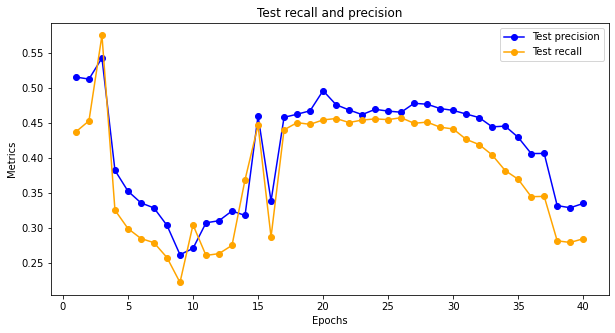

In [9]:
dagmm_trainer.plot_metrics(export_path)

In [25]:
dagmm_trainer.n_epochs = 11
dagmm_trainer.train(train_ldr)

  0%|          | 1/1110 [00:00<02:48,  6.58it/s, epoch=1, loss=0.571]

Started training


100%|██████████| 1110/1110 [01:57<00:00,  9.45it/s, epoch=1, loss=611.891]


AttributeError: 'DAGMMIDSTrainer' object has no attribute 'run_test_validation'

In [ ]:
dagmm_trainer.save_ckpt(export_path + "/checkpoints/dagmm_epoch=11.pt")

In [23]:
dagmm_best = "04-28-2022_20-49-03/checkpoints/dagmm_epoch=11.pt"
dagmm_trainer, dagmm_model = DAGMMIDSTrainer.load_from_file(dagmm_best, dagmm_trainer, dagmm_model)
dagmm_trainer.n_epochs = dagmm_best_epoch
y_test_true, test_scores, test_labels = dagmm_trainer.test(test_ldr)
results = metrics.estimate_optimal_threshold(test_scores, y_test_true)
y_pred = (test_scores >= results["Thresh_star"]).astype(int)
store_results(
    results=results,
    params=dict(batch_size=batch_size, lr=lr, n_epochs=dagmm_best_epoch, **dagmm_model.get_params()),
    model_name="DAGMM",
    dataset="IDS2017",
    dataset_path=dataset_path,
    results_path="./"
)
results

KeyboardInterrupt: 

In [ ]:
dagmm_misclf_df = ids_misclf_per_label(y_pred, y_test_true, test_labels)
dagmm_misclf_df = dagmm_misclf_df.sort_values("Misclassified ratio", ascending=False)
dagmm_misclf_df.to_csv(export_path + "/dagmm_misclassifications.csv")
dagmm_misclf_df